In [1]:
import glob
#from pathlib import Path
import json
import preprocessing as pp
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-12-08 10:29:45.437372: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 10:29:45.437414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 10:29:45.438678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 10:29:45.445574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-08 10:29:46.461959: W tensorflow/compiler/tf2

In [2]:
keys_to_dtype = {
  #'developer_token_id': tf.int64,
  #'resource_token_id': tf.int64,
  #'screen_caption_token_ids': tf.int64,
  #'appdesc_token_id': tf.int64,
  'clickable_seq': tf.int64,
  'type_id_seq': tf.int64,
  'cord_x_seq': tf.float32,
  'cord_y_seq': tf.float32,
  'visibility_to_user_seq': tf.int64,
  'visibility_seq': tf.int64,
  #'attended_objects': tf.int64,
  #'label_flag': tf.int64,  # 0: padding 1: node
  # 'obj_img_mat': tf.int64,
  'obj_dom_pos': tf.int64,
  #'attention_boxes': tf.float32,
  #'gold_caption': tf.string,
}

In [3]:
def get_features_from_gestures(gesture_path):
  with tf.io.gfile.GFile(gesture_path) as f:
    gesture_json = json.load(f)
  trace_path = gesture_path.replace('gestures.json', '')
  # Throw away all gestures except the first
  gesture_items = list(gesture_json.items())
  # Remove empty gestures
  gesture_items = [gesture for gesture in gesture_items if gesture[1]]
  # TODO: Add column: isSwipe, if gesture has more than one entry
  if gesture_items and gesture_items[0]:
    gesture_dict = {gesture[0]:gesture[1][0] for gesture in gesture_items}
  else:
    gesture_dict = {}

  first_gesture_item = list(gesture_dict.items())
  if (not gesture_dict) or (not first_gesture_item[0]) or (not first_gesture_item[0][1]):
    # Return empty dataframe, if no data is available
    return pd.DataFrame(columns=['x', 'y']), trace_path
  
  gesture_df = pd.DataFrame(gesture_dict).transpose()
  gesture_df.columns = ['x', 'y']
  return gesture_df, trace_path

In [4]:
def to_var_len_feature_dict(entries):
  dict = {}
  for feature_item in entries:
    dict[feature_item[0]] = tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])
  return dict


In [5]:
#pathToCombined = "D:/Tmp/Coding/datasets/RICO/unique_uis/test_dataset"
traces_prefix = "../sources/datasets/RICO/traces/filtered_traces"
path_to_gesture_json = f"{traces_prefix}/*/trace_*/gestures.json"
path_to_gesture_json

'../sources/datasets/RICO/traces/filtered_traces/*/trace_*/gestures.json'

In [6]:
gesture_json_paths = glob.glob(path_to_gesture_json)
len(gesture_json_paths)

10292

In [7]:
def get_features_from_tree(frame_index, trace_path):
  file_prefix = f"{trace_path}view_hierarchies/{frame_index}"
  features_dict = pp.create_simple_features(file_prefix)
  del features_dict['node_id']
  feature_items = list(features_dict.items())
  #feature_items = to_var_len_feature_dict(feature_items).items()
  tree_feature_df = pd.DataFrame(feature_items, columns=['feat', frame_index])
  tree_feature_df = tree_feature_df.set_index('feat')
  tree_feature_df = tree_feature_df.transpose()
  return tree_feature_df
  #return pd.DataFrame(features_adapt, index=[frame_index])

In [8]:
gesture_path = gesture_json_paths[42]
gesture_df, trace_path = get_features_from_gestures(gesture_path)
frameIndex = gesture_df.index.values[0]
feature_df = get_features_from_tree(frameIndex, trace_path)
feature_df
#feature_item = features[0]
#feature_item
#tf.convert_to_tensor(feature_item[1], dtype=keys_to_dtype[feature_item[0]])

feat,obj_dom_pos,type_id_seq,visibility_seq,visibility_to_user_seq,clickable_seq,cord_x_seq,cord_y_seq
432,"[1, 1, 68, 2, 2, 67, 2, 67, 2, 2, 68, 1, 3, 3,...","[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[[0.0, 1.0], [0.0, 0.934375], [0.934375, 1.0],..."


In [9]:
# gesture_df['x'].dtype # float64
# gesture_df['y'].dtype # float64

In [10]:
# for t,v in keys_to_dtype.items():
#     print(feature_df[t]['4758'][0].dtype)

In [11]:
# Try without features for now, only gestures
# all_feat_df = pd.concat([gesture_df, feature_df], axis=1)
all_feat_df = gesture_df
all_feat_df

,x,y
432,0.407648,0.272727
514,0.848244,0.890693
705,0.063252,0.071429
947,0.430736,0.405844
2172,0.072872,0.068182
2212,0.242184,0.337662


In [12]:
#feature_df['type_id_seq'].iloc[0][0].dtype

In [13]:
length = 5
n_features=2
label_length=1

In [14]:
 # Get set of frames for each screen, but don't mix them during training LSTM
feature_traces = []
for trace_id, gesture_path in enumerate(gesture_json_paths):
    gesture_df, trace_path = get_features_from_gestures(gesture_path)
    # Traces with too few frames will be dropped
    if len(gesture_df) < (length + label_length):
        continue
    if False: # Try without features for now, only gestures
        tree_features_df = pd.DataFrame()
        for frame_id in gesture_df.index.values:
            tree_feature_df = get_features_tensor_from_tree(frame_id, trace_path)
            tree_features_df = pd.concat([tree_features_df, tree_feature_df], axis=0)
        trace_features_df = pd.concat([gesture_df, tree_features_df], axis=1)
    else:
        trace_features_df = gesture_df
    #trace_features_df = tree_feature_df
    # TODO: save in list of traces
    #trace_features_df['trace_id'] = trace_id
    feature_traces.append(trace_features_df)

len(feature_traces)
        

4278

In [15]:
# TODO: split by trace id
# This is done by trace and not by frame windows as otherwise the model would be trained with similar apps before
test_size = len(feature_traces) // 4
test_ind = len(feature_traces) - test_size

train_traces = feature_traces[:test_ind]
test_traces = feature_traces[test_ind:]

In [16]:
#df['obj_dom_pos'].dtype

In [17]:
from keras.layers import Normalization

scaler = Normalization()
scaler_invert = Normalization(invert=True)

# Adapt scaler
for train in train_traces:
  scaler.adapt(train)
  scaler_invert.adapt(train)

# Scale train data
scaled_train_traces = []
for train in train_traces:
  scaled_train_traces.append(scaler(train))

# Scale test data
scaled_test_traces = []
for test in test_traces:
  scaled_test_traces.append(scaler(test))

print(scaler_invert(scaled_train_traces[0]))

2023-12-08 10:30:23.839297: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 10:30:23.884933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-08 10:30:23.885159: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

tf.Tensor(
[[0.82515633 0.3517316 ]
 [0.37301588 0.22402598]
 [0.56349206 0.89826846]
 [0.16907167 0.3365801 ]
 [0.34607986 0.13636364]
 [0.4134199  0.25757575]
 [0.09018758 0.07034634]
 [0.25757575 0.78679657]
 [0.07864358 0.90043294]
 [0.15945166 0.98051953]], shape=(10, 2), dtype=float32)


In [18]:
scaled_train_traces[0]

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[ 2.997085  ,  0.4924336 ],
       [ 0.67551684, -0.21559192],
       [ 1.6535392 ,  3.5225434 ],
       [-0.37165862,  0.40843067],
       [ 0.53721064, -0.7016095 ],
       [ 0.88297606, -0.02958527],
       [-0.7766983 , -1.0676227 ],
       [ 0.08277594,  2.9045208 ],
       [-0.8359723 ,  3.5345438 ],
       [-0.4210537 ,  3.9785597 ]], dtype=float32)>

In [183]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# # Replace by timeseries_dataset_from_array
# generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
# validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
# len(generator)

In [184]:
# X,y = generator[0]
# X

In [185]:
#y

In [20]:
import functools

def split_window(features):
  inputs = features[:, slice(0, length), :]
  labels = features[:, slice(length, length + label_length), :]
  return inputs, labels

def make_dataset(data):
  ds = tf.keras.utils.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=length + label_length,
    sequence_stride=1,
    shuffle=False, # TODO: Shuffle if possible
    batch_size=32,)

  ds = ds.map(split_window)
  return ds

train_dataset_list = list(map(make_dataset,scaled_train_traces))
dataset = functools.reduce(lambda a, b: a.concatenate(b), train_dataset_list)

test_dataset_list = list(map(make_dataset,scaled_test_traces))
validation_dataset = functools.reduce(lambda a, b: a.concatenate(b), test_dataset_list)
# dataset
# dataset = tf.data.Dataset.from_tensor_slices(scaled_train).window(length, drop_remainder=True)
# for inputs, labels in dataset:
#     print(len(inputs))
#     print(list(inputs.numpy()))

inputs, labels = next(iter(dataset))
inputs

<tf.Tensor: shape=(5, 5, 2), dtype=float32, numpy=
array([[[ 2.997085  ,  0.4924336 ],
        [ 0.67551684, -0.21559192],
        [ 1.6535392 ,  3.5225434 ],
        [-0.37165862,  0.40843067],
        [ 0.53721064, -0.7016095 ]],

       [[ 0.67551684, -0.21559192],
        [ 1.6535392 ,  3.5225434 ],
        [-0.37165862,  0.40843067],
        [ 0.53721064, -0.7016095 ],
        [ 0.88297606, -0.02958527]],

       [[ 1.6535392 ,  3.5225434 ],
        [-0.37165862,  0.40843067],
        [ 0.53721064, -0.7016095 ],
        [ 0.88297606, -0.02958527],
        [-0.7766983 , -1.0676227 ]],

       [[-0.37165862,  0.40843067],
        [ 0.53721064, -0.7016095 ],
        [ 0.88297606, -0.02958527],
        [-0.7766983 , -1.0676227 ],
        [ 0.08277594,  2.9045208 ]],

       [[ 0.53721064, -0.7016095 ],
        [ 0.88297606, -0.02958527],
        [-0.7766983 , -1.0676227 ],
        [ 0.08277594,  2.9045208 ],
        [-0.8359723 ,  3.5345438 ]]], dtype=float32)>

In [21]:
labels

<tf.Tensor: shape=(5, 1, 2), dtype=float32, numpy=
array([[[ 0.88297606, -0.02958527]],

       [[-0.7766983 , -1.0676227 ]],

       [[ 0.08277594,  2.9045208 ]],

       [[-0.8359723 ,  3.5345438 ]],

       [[-0.4210537 ,  3.9785597 ]]], dtype=float32)>

In [22]:
from keras.models import Sequential
from keras.layers import Dense,LSTM
from keras.callbacks import EarlyStopping

In [27]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss',patience=4)

In [28]:
model.fit(dataset,epochs=50,
                    validation_data=validation_dataset,
                    callbacks=[early_stop])

Epoch 1/50
3231/3231 [==============================] - 78s 23ms/step - loss: 2.5162 - val_loss: 2.5182
Epoch 2/50
3231/3231 [==============================] - 70s 22ms/step - loss: 2.5032 - val_loss: 2.5184
Epoch 3/50
3231/3231 [==============================] - 76s 24ms/step - loss: 2.5012 - val_loss: 2.5174
Epoch 4/50
3231/3231 [==============================] - 70s 22ms/step - loss: 2.4998 - val_loss: 2.5166
Epoch 5/50
3231/3231 [==============================] - 70s 22ms/step - loss: 2.4989 - val_loss: 2.5169
Epoch 6/50
3231/3231 [==============================] - 70s 22ms/step - loss: 2.4982 - val_loss: 2.5175
Epoch 7/50
3231/3231 [==============================] - 70s 22ms/step - loss: 2.4979 - val_loss: 2.5178
Epoch 8/50
3231/3231 [==============================] - 69s 21ms/step - loss: 2.4977 - val_loss: 2.5191


<AxesSubplot: >

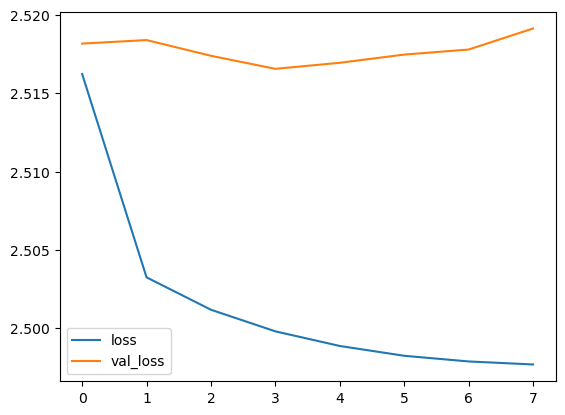

In [29]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [72]:
## Evaluate on Test Data

In [52]:
scaled_train_traces_lengths = list(map(len, scaled_test_traces))
# Get the longest trace
longest_scaled_train_trace = max(scaled_train_traces_lengths)
print(longest_scaled_train_trace)
index_longest_scaled_train_trace = scaled_train_traces_lengths.index(max(scaled_train_traces_lengths))
print(index_longest_scaled_train_trace)

50
657


In [53]:
my_prediction_trace = index_longest_scaled_train_trace
scaled_train = scaled_test_traces[my_prediction_trace]

In [59]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = tf.reshape(first_eval_batch, (1, length, n_features), name=None)

for i in range(len(test)):

  # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
  current_pred = model.predict(current_batch)[0]

  # store prediction
  test_predictions.append(current_pred)

  # update batch to now include prediction and drop first value
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 19ms/step


In [60]:
true_predictions = scaler_invert(test_predictions)
test[['PredictionsX', 'PredictionsY']] = true_predictions

In [61]:
test

,x,y,PredictionsX,PredictionsY
859,0.076720,0.077922,0.430469,0.318399
870,0.207552,0.255411,0.402668,0.326663
892,0.086340,0.079004,0.388115,0.330901
921,0.296056,0.320346,0.376984,0.343233
961,0.061328,0.076840,0.374387,0.367625
972,0.228716,0.411255,0.404930,0.393860
999,0.105580,0.074675,0.408515,0.400848
1015,0.244108,0.470779,0.411002,0.405288
1055,0.215248,0.533550,0.412937,0.408607
1092,0.474988,0.338745,0.414144,0.410848


<AxesSubplot: >

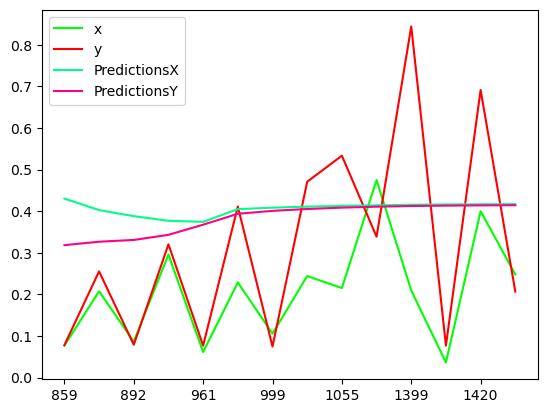

In [62]:
test.plot(color = ['#00FF00', '#FF0000', '#00FF88', '#FF0088'])

In [63]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(test['x'],test['PredictionsX'])))
print(np.sqrt(mean_squared_error(test['y'],test['PredictionsY'])))

0.23421116461721828
0.23345033378661953
